In [7]:
#pip install pyBigWig

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
from bisect import bisect_left
from scipy import stats
import pyBigWig
import matplotlib.pyplot as plt
def fn(myList, myNumber):
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before 
data='../data/'    

In [10]:
man=pd.read_csv(data+'source/epic_cor.csv',index_col=0)
man.shape

(198654, 12)

In [13]:
%%time
#gencode from USCS browser
genc=pd.read_table(data+'source/gencode.txt',index_col=0)
genc.columns=range(1,6)
genc=genc[genc[1].isin(['chr'+str(c) for c in range(1,23)])].copy()
genc['tss']=genc.apply(lambda x: int(x[1][3:])*10**9+x[3] if x[2]=='+' else int(x[1][3:])*10**9+x[4],axis=1)
genc=genc[genc[5].str[:4]!='ENSG'].copy()
genc=genc[genc[5].str[:4]!='LINC'].copy()
genc=genc[genc[5].str[:3]!='MIR'].copy()
genc=genc[genc[5].str[:3]!='RPL'].copy()
genc=genc[genc[5].str[-3:]!='-DT'].copy()
genc=genc[genc[5].str[-4:-1]!='-AS'].copy()
ts=genc[[5,'tss']].drop_duplicates().groupby('tss')[5].agg("min")
ts.shape

CPU times: user 9.83 s, sys: 275 ms, total: 10.1 s
Wall time: 10.1 s


(159017,)

In [31]:
genc

,1,2,3,4,5,tss
#hg38.knownGene.name,,,,,,
ENST00000456328.2,chr1,+,11868,14409,DDX11L2,1000011868
ENST00000450305.2,chr1,+,12009,13670,DDX11L1,1000012009
ENST00000488147.1,chr1,-,14403,29570,WASH7P,1000029570
ENST00000417324.1,chr1,-,34553,36081,FAM138A,1000036081
ENST00000461467.1,chr1,-,35244,36073,FAM138A,1000036073
...,...,...,...,...,...,...
ENST00000464678.5,chr22,-,50769781,50783286,RABL2B,22050783286
ENST00000395590.5,chr22,-,50771209,50783630,RABL2B,22050783630
ENST00000468451.1,chr22,-,50775770,50783600,RABL2B,22050783600


In [ ]:
%%time
#gencode from biomart: Attributes, Protein stable ID, Transcript stable ID, Gene name, Chromosome, Transcription start site (TSS)
gencp=pd.read_table(data+'source/biomart.txt',index_col=1)
gencp=gencp[gencp['Protein stable ID'].notna()].copy()
gencp['tss']=gencp['Chromosome/scaffold name']*10**9+gencp['Transcription start site (TSS)']
ts=gencp[['Gene name','tss']].drop_duplicates().groupby('tss')['Gene name'].agg("first")
ts.shape

In [21]:
%%time
df=man.copy()
dis=[]
gen=[]
for i,b in df[['g']].iterrows():
    fns=fn(ts.index,b['g'])
    dis.append(np.abs(b['g']-fns))
    gen.append(ts.loc[fns])     
df['dis']=dis
df['Gene']=gen

CPU times: user 10.2 s, sys: 57.8 ms, total: 10.2 s
Wall time: 10.2 s


In [22]:
df['DNAm by age']=(df['cor']>0).replace({True:'Gain',False:'Loss'})
df['dis_l']=np.log10(df['dis']+1)

/data/gladyshev/mm1286/miniconda3/envs/integrative/lib/python3.12/site-packages/seaborn/axisgrid.py:1766: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  f.tight_layout()


CPU times: user 5.19 s, sys: 82.3 ms, total: 5.27 s
Wall time: 1.76 s


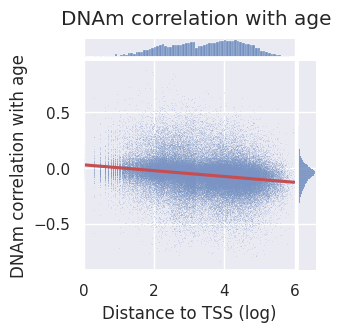

In [23]:
%%time
sns.set(rc={'figure.figsize':(3,3)})
pl=df.sample(10**5)
ax=sns.jointplot(data=pl,x='dis_l',y='cor',kind='scatter', s= .1,height=3,ratio=10)
sns.regplot(data=pl, y='cor', x='dis_l', scatter=False, ax=ax.ax_joint, ci=None,color='r');
ax.ax_joint.set(xlim=[0,6]);
plt.suptitle("DNAm correlation with age");
ax.ax_joint.set(ylabel='DNAm correlation with age',xlabel='Distance to TSS (log)');

/tmp/ipykernel_206205/2793830341.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, size = 10);


[(-0.4, 0.4)]

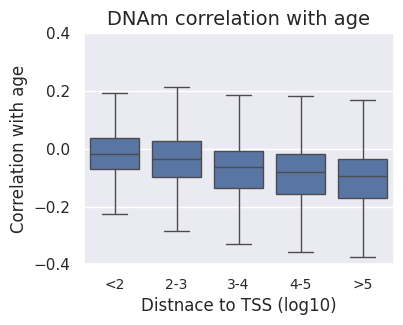

In [24]:
sns.set(rc={'figure.figsize':(4,3)})
labels=['<2','2-3','3-4','4-5','>5']
df['dis_c']=pd.cut(df['dis'],[0,100,10**3,10**4,10**5,10**7],labels=labels)
ax=sns.boxplot(data=df.head(10**6),x='dis_c',y='cor',flierprops={"marker": ".",'markersize':1},showfliers=False)#,s=1);
#ax=sns.stripplot(data=dg.head(10**6),x='blood_c',y='adj-p',hue='dir',s=2,color='red');
ax.set_title('DNAm correlation with age',fontsize=14) 
ax.set(ylabel='Correlation with age',xlabel='Distnace to TSS (log10)');
ax.set_xticklabels(labels, size = 10);
ax.set(ylim=[-.4,.4])
#plt.legend(loc=(1, .5))

In [27]:
gt=pd.read_table(data+'source/GTEx_Analysis_2017-06-05_v8_RNASeQCv1.1.9_gene_median_tpm.gct',
              skiprows=2,index_col=0)
gt=gt.groupby('Description').mean()
gt=gt.rename(columns={'Minor Salivary Gland':'Salivary Gland',
                     'Whole Blood':'blood','Skin - Not Sun Exposed (Suprapubic)':'skin protect', 'Skin - Sun Exposed (Lower leg)':'skin expose'})
dg=df.merge(gt[['blood','skin protect', 'skin expose']],left_on='Gene',right_index=True)
dg['skin']=dg[['skin protect', 'skin expose']].mean(1)
dg=dg[dg['dis']<=100].copy() ### 100 fromTSS

In [28]:
labels=['0-1','1-10','10-100','100+']
dg['blood_c']=pd.cut(dg['blood'],[-1,1,10,100,10**6],labels=labels)
#dg['blood_log']=np.log(dg['blood']+1)
dg['adj-p']=-np.log10(stats.false_discovery_control(dg['p']))

/tmp/ipykernel_206205/3520863200.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, size = 9);


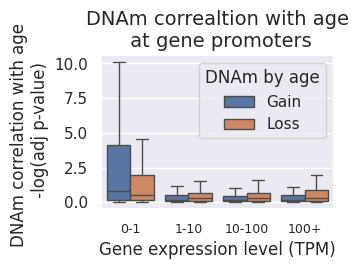

In [29]:
sns.set(rc={'figure.figsize':(3,2)})
ax=sns.boxplot(data=dg.head(10**6),x='blood_c',y='adj-p',hue='DNAm by age',hue_order=['Gain','Loss'],showfliers=False)#,s=1);
#ax=sns.stripplot(data=dg.head(10**6),x='blood_c',y='adj-p',hue='dir',s=2,color='red');
ax.set_title('DNAm correaltion with age\n at gene promoters',fontsize=14) 
ax.set(ylabel='DNAm correlation with age \n -log(adj p-value)',xlabel='Gene expression level (TPM)');
ax.set_xticklabels(labels, size = 9);

/tmp/ipykernel_206205/2390701947.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, size = 10);


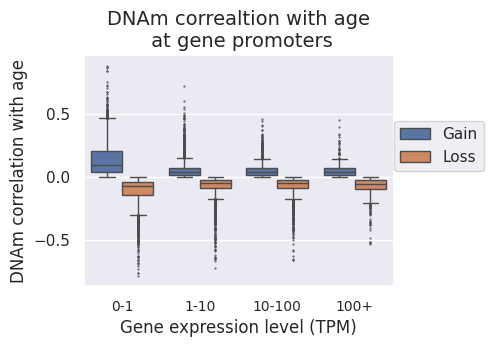

In [30]:
sns.set(rc={'figure.figsize':(4,3)})
ax=sns.boxplot(data=dg.head(10**6),x='blood_c',y='cor',hue='DNAm by age',hue_order=['Gain','Loss'],flierprops={"marker": ".",'markersize':1})#,showfliers=False)#,s=1);
#ax=sns.stripplot(data=dg.head(10**6),x='blood_c',y='adj-p',hue='dir',s=2,color='red');
ax.set_title('DNAm correaltion with age\n at gene promoters',fontsize=14) 
ax.set(ylabel='DNAm correlation with age',xlabel='Gene expression level (TPM)');
ax.set_xticklabels(labels, size = 10);
plt.legend(loc=(1, .5))

In [34]:
%%time
chip=pyBigWig.open(data+'source/ENCFF109KCQ.bigWig') # ENCODE EZH2 ESC P-Values
ez=[]
for i,r in dg.iterrows():
    ez.append(chip.stats(r['chr'],r['pos'],r['pos']+1)[0])

CPU times: user 3.45 s, sys: 363 ms, total: 3.82 s
Wall time: 13.6 s


In [35]:
dg['ez']=ez
dg[['cor','ez']].corr()

,cor,ez
cor,1.000000,0.228723
ez,0.228723,1.000000


[Text(0, 0.5, 'DNAm correlation with age'), Text(0.5, 0, 'PRC2 binding')]

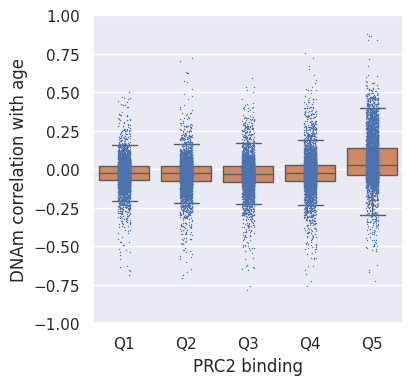

In [36]:
dg['ez_c']=pd.qcut(dg['ez'],5,labels=['Q'+str(c) for c in range(1,6)])
sns.set(rc={'figure.figsize':(4,4)})
ax=sns.stripplot(data=dg.head(10**6),x='ez_c',y='cor',s=1)
ax=sns.boxplot(data=dg.head(10**6),x='ez_c',y='cor',showfliers=False)
#ax.axhline(-.6, ls='--',color='red')
#ax.axhline(.6, ls='--',color='red')
ax.set(ylim=[-1,1])
ax.set(ylabel='DNAm correlation with age',xlabel='PRC2 binding')

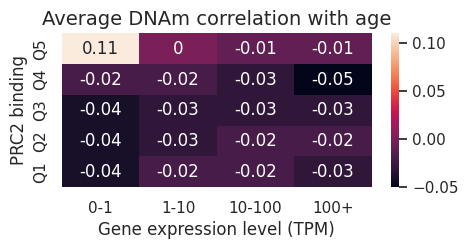

In [37]:
sns.set(rc={'figure.figsize':(5,2)})
glue=dg.groupby(['blood_c','ez_c'],observed=True)['cor'].mean().round(2)
glue=glue.reset_index()
glue=glue.pivot(index='blood_c',columns='ez_c',values='cor')[['Q'+ str(q) for q in range(5,0,-1)]].T
ax=sns.heatmap(glue,annot=True)#,annot_kws={'color':'red'})
ax.set_title('Average DNAm correlation with age',fontsize=14) 
ax.set(ylabel='PRC2 binding',xlabel='Gene expression level (TPM)');